In [ ]:
# Optimized and Extended Deep Q-Learning for Energy Consumption Reduction

import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam

In [ ]:
# Environment Class: Simulates the Data Center
temp_logs_ai = []
temp_logs_noai = []
energy_logs_ai = []
energy_logs_noai = []

class Environment:
    def __init__(self, optimal_temperature=(18.0, 24.0), initial_month=0, initial_number_users=10, initial_rate_data=60):
        self.monthly_atmospheric_temperatures = [1.0, 5.0, 7.0, 10.0, 11.0, 20.0, 23.0, 24.0, 22.0, 10.0, 5.0, 1.0]
        self.optimal_temperature = optimal_temperature
        self.min_temperature, self.max_temperature = -20, 80
        self.min_number_users, self.max_number_users, self.max_update_users = 10, 100, 5
        self.min_rate_data, self.max_rate_data, self.max_update_data = 20, 300, 10
        self.initial_month = initial_month
        self.initial_number_users = initial_number_users
        self.initial_rate_data = initial_rate_data
        self.reset(initial_month)

    def update_env(self, direction, energy_ai, month):
        energy_noai = 0
        if self.temperature_noai < self.optimal_temperature[0]:
            energy_noai = self.optimal_temperature[0] - self.temperature_noai
            self.temperature_noai = self.optimal_temperature[0]
        elif self.temperature_noai > self.optimal_temperature[1]:
            energy_noai = self.temperature_noai - self.optimal_temperature[1]
            self.temperature_noai = self.optimal_temperature[1]

        self.reward = 1e-3 * (energy_noai - energy_ai)
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[month]

        self.current_number_users += np.random.randint(-self.max_update_users, self.max_update_users)
        self.current_number_users = np.clip(self.current_number_users, self.min_number_users, self.max_number_users)

        self.current_rate_data += np.random.randint(-self.max_update_data, self.max_update_data)
        self.current_rate_data = np.clip(self.current_rate_data, self.min_rate_data, self.max_rate_data)

        past_intrinsic_temperature = self.intrinsic_temperature
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users + 1.25 * self.current_rate_data
        delta_intrinsic_temperature = self.intrinsic_temperature - past_intrinsic_temperature

        delta_temperature_ai = energy_ai if direction == 1 else -energy_ai
        self.temperature_ai += delta_intrinsic_temperature + delta_temperature_ai
        self.temperature_noai += delta_intrinsic_temperature

        if self.temperature_ai < self.min_temperature:
            self.temperature_ai = self.optimal_temperature[0]
            self.total_energy_ai += self.optimal_temperature[0] - self.temperature_ai
        elif self.temperature_ai > self.max_temperature:
            self.total_energy_ai += self.temperature_ai - self.optimal_temperature[1]
            self.temperature_ai = self.optimal_temperature[1]

        self.total_energy_ai += energy_ai
        self.total_energy_noai += energy_noai

        temp_logs_ai.append(self.temperature_ai)
        temp_logs_noai.append(self.temperature_noai)
        energy_logs_ai.append(self.total_energy_ai)
        energy_logs_noai.append(self.total_energy_noai)

        next_state = np.array([
            (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),
            (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),
            (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data)
        ]).reshape(1, -1)

        return next_state, self.reward

    def reset(self, new_month):
        self.current_number_users = self.initial_number_users
        self.current_rate_data = self.initial_rate_data
        self.atmospheric_temperature = self.monthly_atmospheric_temperatures[new_month]
        self.intrinsic_temperature = self.atmospheric_temperature + 1.25 * self.current_number_users + 1.25 * self.current_rate_data
        self.temperature_ai = self.intrinsic_temperature
        self.temperature_noai = sum(self.optimal_temperature) / 2.0
        self.total_energy_ai = 0.0
        self.total_energy_noai = 0.0

    def observe(self):
        return np.array([
            (self.temperature_ai - self.min_temperature) / (self.max_temperature - self.min_temperature),
            (self.current_number_users - self.min_number_users) / (self.max_number_users - self.min_number_users),
            (self.current_rate_data - self.min_rate_data) / (self.max_rate_data - self.min_rate_data)
        ]).reshape(1, -1)


In [ ]:
# Brain (Neural Network)
class Brain:
    def __init__(self, learning_rate=0.0001, number_actions=5):
        states = Input(shape=(3,))
        x = Dense(64, activation='relu')(states)
        x = Dense(32, activation='relu')(x)
        q_values = Dense(number_actions, activation='softmax')(x)
        self.model = Model(inputs=states, outputs=q_values)
        self.model.compile(optimizer=Adam(learning_rate), loss='mse')

In [ ]:
# DQN: Memory and Learning
class DQN:
    def __init__(self, max_memory=2000, discount=0.9):
        self.memory = []
        self.max_memory = max_memory
        self.discount = discount

    def remember(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.max_memory:
            self.memory.pop(0)

    def get_batch(self, model, batch_size=32):
        inputs, targets = [], []
        indices = np.random.choice(len(self.memory), min(batch_size, len(self.memory)))
        for idx in indices:
            state, action, reward, next_state = self.memory[idx]
            target = model.predict(state)[0]
            Q_next = np.max(model.predict(next_state)[0])
            target[action] = reward + self.discount * Q_next
            inputs.append(state[0])
            targets.append(target)
        return np.array(inputs), np.array(targets)

In [ ]:
# Train Model
def train_model():
    np.random.seed(42)
    random.seed(42)
    env = Environment()
    brain = Brain()
    dqn = DQN()

    model = brain.model
    epsilon = 0.3
    direction_boundary = 2
    temperature_step = 1.5
    epochs = 4  # Reduced for faster experimentation
    timesteps_per_epoch = 50  # Reduced from 2000

    for epoch in range(epochs):
        env.reset(np.random.randint(0, 12))
        state = env.observe()
        total_reward = 0
        for timestep in range(timesteps_per_epoch):
            if np.random.rand() < epsilon:
                action = np.random.randint(0, 5)
            else:
                q_values = model.predict(state, verbose=0)[0]
                action = np.argmax(q_values)
            direction = -1 if action < direction_boundary else 1
            energy_ai = abs(action - direction_boundary) * temperature_step
            next_state, reward = env.update_env(direction, energy_ai, timestep % 12)
            dqn.remember((state, action, reward, next_state))
            state = next_state
            total_reward += reward

            if timestep % 10 == 0 and len(dqn.memory) > 32:  # Train every 10 steps
                inputs, targets = dqn.get_batch(model)
                model.train_on_batch(inputs, targets)

        print(f"Epoch {epoch+1}/{epochs}, Total Reward: {total_reward:.2f}, AI Energy: {env.total_energy_ai:.2f}, No AI Energy: {env.total_energy_noai:.2f}")

    model.save("energy_optimizer_dqn.h5")

    plt.plot(temp_logs_ai, label="AI Temperature")
    plt.plot(temp_logs_noai, label="No AI Temperature")
    plt.legend()
    plt.title("Temperature Comparison")
    plt.xlabel("Timestep")
    plt.ylabel("Temperature")
    plt.show()

    plt.plot(energy_logs_ai, label="AI Energy")
    plt.plot(energy_logs_noai, label="No AI Energy")
    plt.legend()
    plt.title("Energy Consumption Comparison")
    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Energy")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

Epoch 4/4, Total Reward: 0.17, AI Energy: 225.50, No AI Energy: 273.00


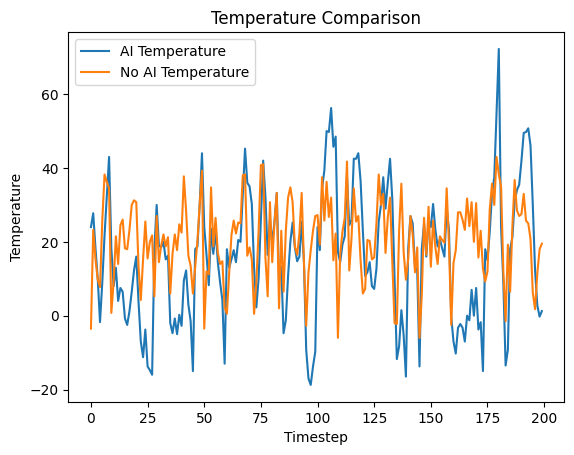

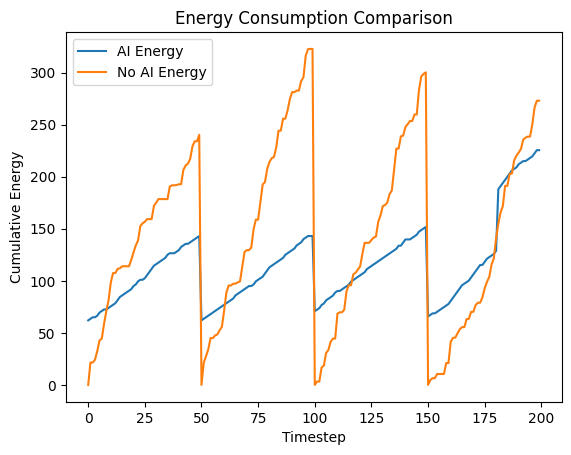

In [ ]:
# Run the training
train_model()